# Lag-Llama Fine Tuning

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 127 (delta 40), reused 45 (delta 23), pack-reused 55
Receiving objects: 100% (127/127), 192.24 KiB | 14.79 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
cd /content/lag-llama

[Errno 2] No such file or directory: '/content/lag-llama'
/Users/junbo/studium/ma/code/lag_llama_model


In [18]:
!pip install -r requirements.txt --quiet

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [19]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /code/lag_llama_model

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /Users/junbo/.cache/huggingface/hub/tmp8fdu1ggm
lag-llama.ckpt: 100%|██████████████████████| 29.5M/29.5M [00:03<00:00, 9.70MB/s]
Traceback (most recent call last):
  File "/Users/junbo/miniconda3/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/junbo/miniconda3/lib/python3.11/site-packages/huggingface_hub/commands/huggingface_cli.py", line 49, in main
    service.run()
  File "/Users/junbo/miniconda3/lib/python3.11/site-packages/huggingface_hub/commands/download.py", line 161, in run
    print(self._download())  # Print path to downloaded files
          ^^^^^^^^^^^^^^^^
  File "/Users/junbo/miniconda3/lib/python3.11/site-packages/huggingface_hub/commands/download.

## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [45]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [46]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
for key, value in ckpt.items():
    print(key)
   # print(value)

epoch
global_step
pytorch-lightning_version
state_dict
loops
callbacks
optimizer_states
lr_schedulers
hparams_name
hyper_parameters


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [36]:
def get_lag_llama_predictions(dataset, 
                              prediction_length, 
                              context_length=32, 
                              num_samples=20, 
                              device="cuda", 
                              batch_size=64, 
                              nonnegative_pred_samples=True):
    
##    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))

    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

## Zero Shot on `M4-Weekly`

In [68]:
dataset = get_dataset("m4_weekly")
# get_dataset("")
dataset.train
dataset.test

DatasetCollection(datasets=[Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x14900e9f0>, iterable=JsonLinesFile(path=PosixPath('/Users/junbo/.gluonts/datasets/m4_weekly/test/data.json.gz'), start=0, n=None, line_starts=[0, 20016, -29671, -12361, 9996, 23017, -30446, -17286, -4095, 9594, 17694, 25877, 29693, -28783, -21751, -15683, -9615, -2869, 3431, 16587, 29595, -22921, -9767, 2387, 15910, 28860, -23462, -10453, 2679, 15476, 28506, -24468, -11276, 1737, 14608, 27563, -30100, -25839, -21477, -8832, 4036, 13083, 22108, 31589, -21313, -9820, -24, 11475, 23765, -32625, -23492, -15111, -6691, 3162, 9995, 23135, 32301, -30138, -24661, -21729, -485, 12856, 30264, -17864, -79, 17827, -31286, -20517, -14544, -9853, -5345, -1164, 3017, 7198, 13266, 19377, 21511, 27694, -31650, -25705, -19760, -13643, -1000, 3057, 7114, 13295, 19476, 23051, -21895, -12394, -2219, 19625, -25134, -18559, -15908, -13258, 9373, 29086, -16465, 4787, 25824, 29788, -14372, 5643, 9213, 29425, -29536, -8430, 

In [58]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 50
device = "mps"

In [59]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Ground truth: 100%|██████████| 718/718 [00:00<00:00, 3711.80it/s]


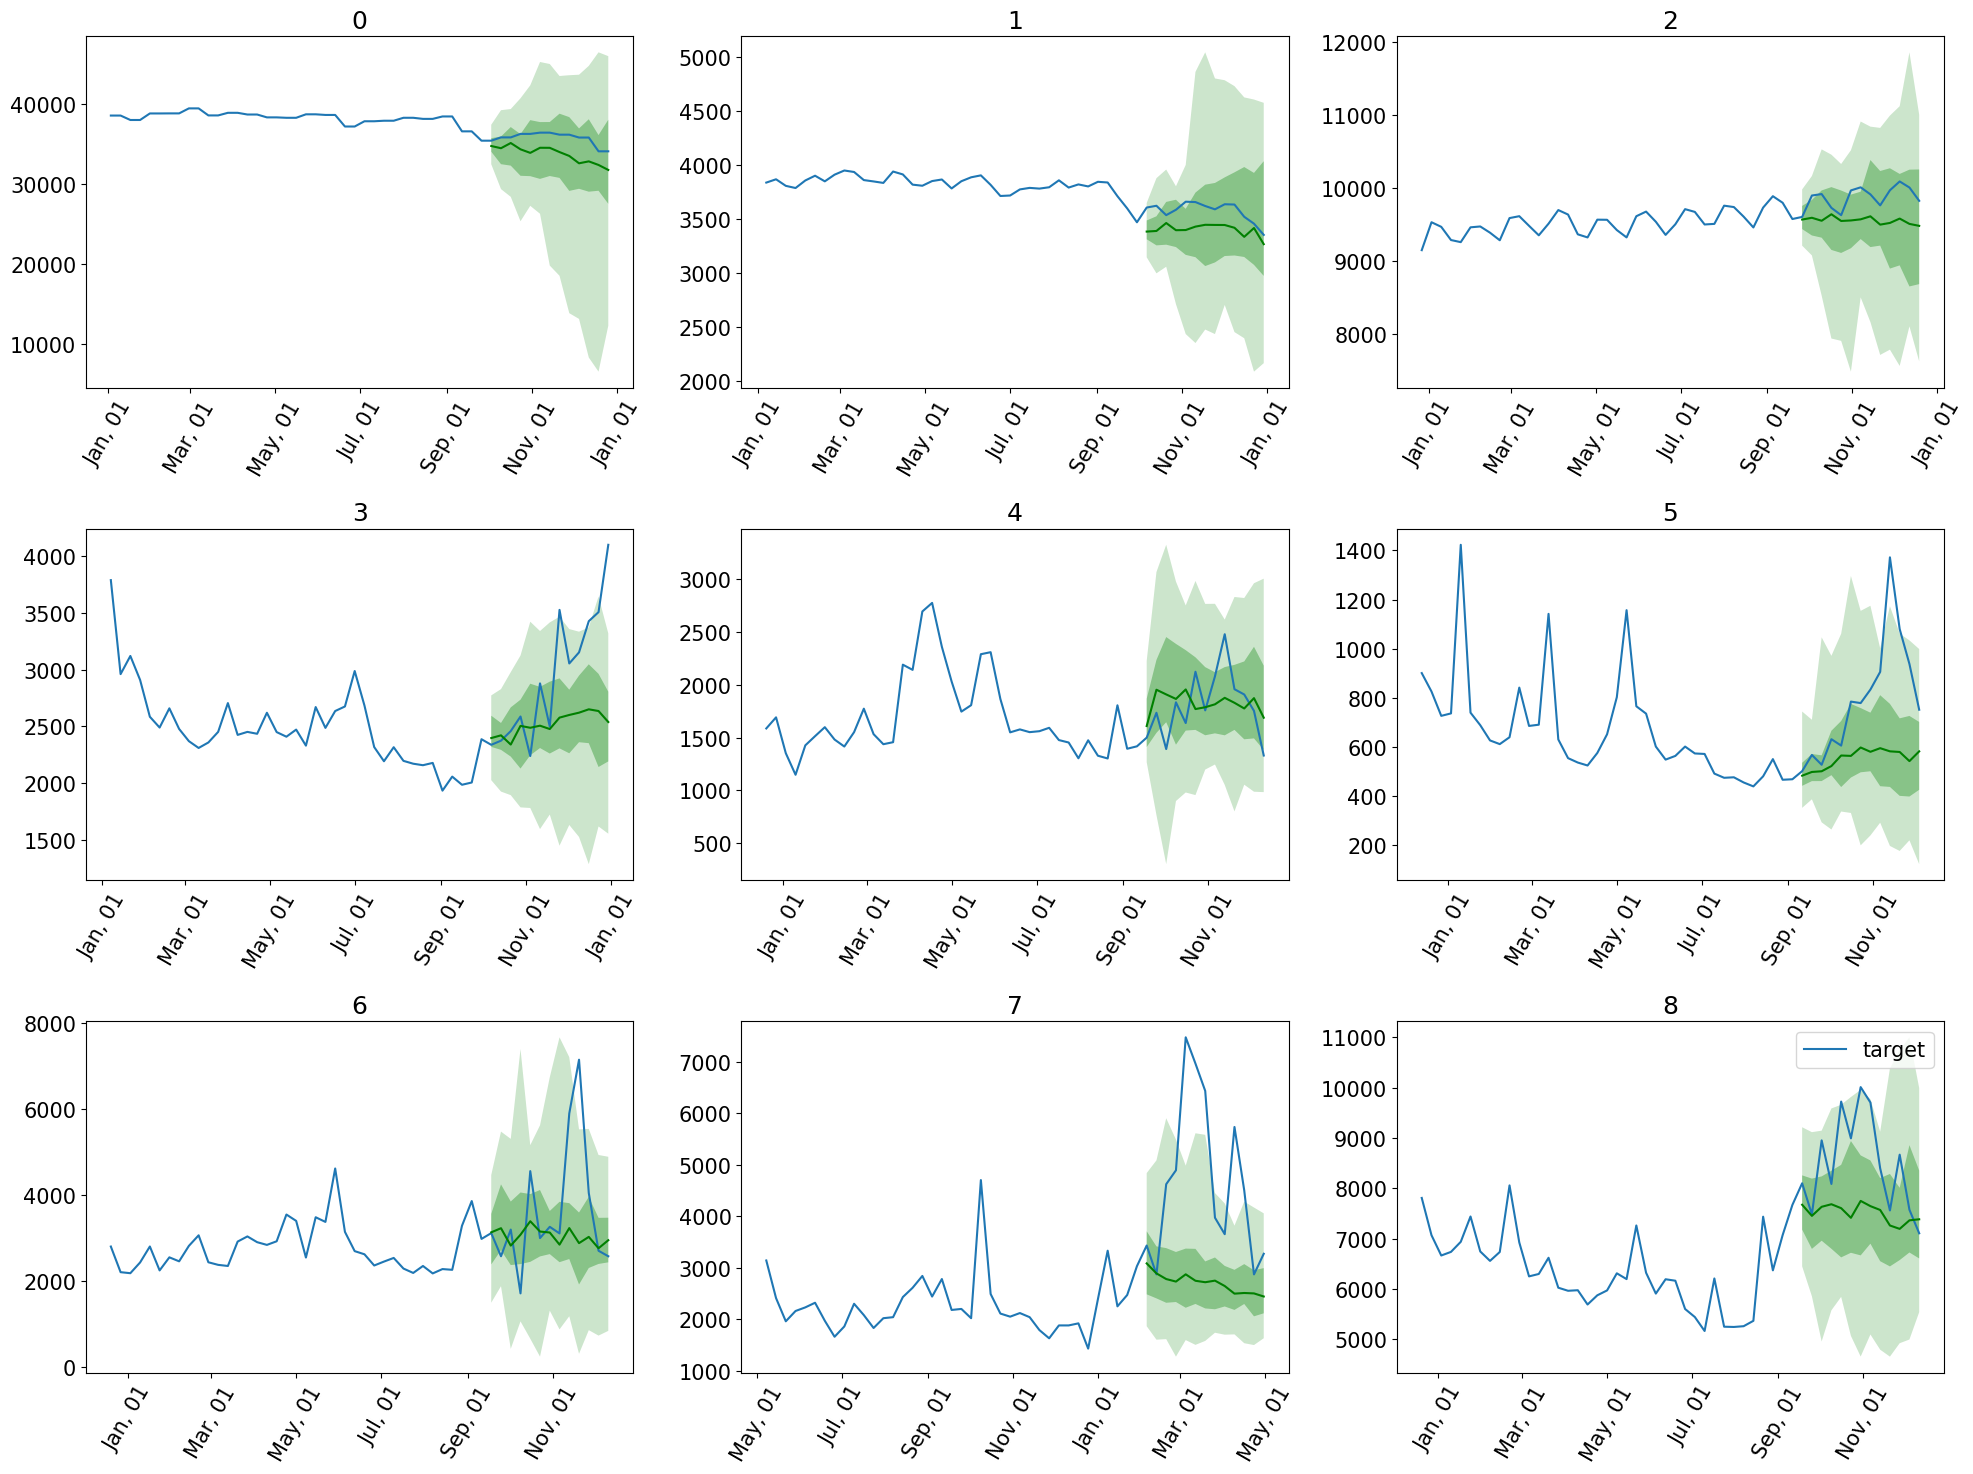

In [62]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [7]:
##ckpt = torch.load("lag-llama.ckpt", map_location=device)
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [48]:
dataset.train

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x159fb3cb0>, iterable=JsonLinesFile(path=PosixPath('/Users/junbo/.gluonts/datasets/traffic/train/data.json.gz'), start=0, n=None, line_starts=[0, 110826, 221439, 332185, 442643, 553153, 664012, 774792, 885255, 995773, 1106603, 1217265, 1327790, 1438503, 1549104, 1659538, 1770118, 1880343, 1990791, 2101369, 2211780, 2322870, 2433634, 2544250, 2654904, 2765220, 2875982, 2986440, 3096786, 3207472, 3318172, 3428927, 3539499, 3649979, 3760628, 3871477, 3982165, 4092969, 4203765, 4314404, 4425563, 4536404, 4646801, 4757558, 4868240, 4979038, 5089512, 5200402, 5310760, 5421527, 5532213, 5642839, 5753403, 5863934, 5974623, 6085515, 6196111, 6306700, 6417523, 6528318, 6638863, 6749237, 6859771, 6970252, 7080980, 7191519, 7302251, 7412938, 7523601, 7634459, 7745191, 7855895, 7966471, 8077001, 8185003, 8295588, 8405968, 8516659, 8627256, 8738099, 8848793, 8959587, 9070312, 9180892, 9291500, 9402314, 9512842, 9623389, 9733845, 9844717, 995

In [8]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)
# training took: 

# predictor = estimator.train(train_data)
# forecasts = predictor.predict(data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/junbo/studium/ma/code/lag_llama_model/lightning_logs

  | Nam

Epoch 0: |          | 50/? [00:24<00:00,  2.03it/s, v_num=0]

Epoch 0, global step 50: 'train_loss' reached 8.27877 (best 8.27877), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:17<00:00,  2.89it/s, v_num=0]

Epoch 1, global step 100: 'train_loss' reached 7.02655 (best 7.02655), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:16<00:00,  3.02it/s, v_num=0]

Epoch 2, global step 150: 'train_loss' reached 6.83400 (best 6.83400), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:17<00:00,  2.81it/s, v_num=0]

Epoch 3, global step 200: 'train_loss' reached 6.75871 (best 6.75871), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:15<00:00,  3.29it/s, v_num=0]

Epoch 4, global step 250: 'train_loss' reached 6.74234 (best 6.74234), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:15<00:00,  3.24it/s, v_num=0]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |          | 50/? [00:15<00:00,  3.29it/s, v_num=0]

Epoch 6, global step 350: 'train_loss' reached 6.66704 (best 6.66704), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:15<00:00,  3.25it/s, v_num=0]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:16<00:00,  3.08it/s, v_num=0]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:16<00:00,  2.94it/s, v_num=0]

Epoch 9, global step 500: 'train_loss' reached 6.52441 (best 6.52441), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:19<00:00,  2.56it/s, v_num=0]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [12:53<00:00,  0.06it/s, v_num=0]

Epoch 11, global step 600: 'train_loss' reached 6.50066 (best 6.50066), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:17<00:00,  2.93it/s, v_num=0]

Epoch 12, global step 650: 'train_loss' reached 6.46616 (best 6.46616), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:18<00:00,  2.63it/s, v_num=0]

Epoch 13, global step 700: 'train_loss' reached 6.37266 (best 6.37266), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:17<00:00,  2.92it/s, v_num=0]

Epoch 14, global step 750: 'train_loss' reached 6.37050 (best 6.37050), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [00:16<00:00,  3.11it/s, v_num=0]

Epoch 15, global step 800: 'train_loss' reached 6.35586 (best 6.35586), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:15<00:00,  3.16it/s, v_num=0]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:16<00:00,  3.12it/s, v_num=0]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:15<00:00,  3.13it/s, v_num=0]

Epoch 18, global step 950: 'train_loss' reached 6.29765 (best 6.29765), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:16<00:00,  3.11it/s, v_num=0]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:15<00:00,  3.15it/s, v_num=0]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:18<00:00,  2.71it/s, v_num=0]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [1:04:28<00:00,  0.01it/s, v_num=0]

Epoch 22, global step 1150: 'train_loss' reached 6.29720 (best 6.29720), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:15<00:00,  3.26it/s, v_num=0]  

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [07:46<00:00,  0.11it/s, v_num=0]

Epoch 24, global step 1250: 'train_loss' reached 6.23779 (best 6.23779), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [13:30<00:00,  0.06it/s, v_num=0]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:16<00:00,  3.06it/s, v_num=0]

Epoch 26, global step 1350: 'train_loss' reached 6.23069 (best 6.23069), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:17<00:00,  2.90it/s, v_num=0]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:17<00:00,  2.88it/s, v_num=0]

Epoch 28, global step 1450: 'train_loss' reached 6.21951 (best 6.21951), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:15<00:00,  3.14it/s, v_num=0]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:17<00:00,  2.84it/s, v_num=0]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:16<00:00,  3.11it/s, v_num=0]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:20<00:00,  2.48it/s, v_num=0]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:23<00:00,  2.10it/s, v_num=0]

Epoch 33, global step 1700: 'train_loss' reached 6.19043 (best 6.19043), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:19<00:00,  2.58it/s, v_num=0]

Epoch 34, global step 1750: 'train_loss' reached 6.14679 (best 6.14679), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:20<00:00,  2.44it/s, v_num=0]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:18<00:00,  2.63it/s, v_num=0]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:19<00:00,  2.62it/s, v_num=0]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:18<00:00,  2.65it/s, v_num=0]

Epoch 38, global step 1950: 'train_loss' reached 6.14007 (best 6.14007), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:17<00:00,  2.84it/s, v_num=0]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:15<00:00,  3.16it/s, v_num=0]

Epoch 40, global step 2050: 'train_loss' reached 6.13064 (best 6.13064), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:15<00:00,  3.16it/s, v_num=0]

Epoch 41, global step 2100: 'train_loss' reached 6.10365 (best 6.10365), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:15<00:00,  3.15it/s, v_num=0]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:15<00:00,  3.14it/s, v_num=0]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:15<00:00,  3.18it/s, v_num=0]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:16<00:00,  3.09it/s, v_num=0]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:15<00:00,  3.17it/s, v_num=0]

Epoch 46, global step 2350: 'train_loss' reached 6.09056 (best 6.09056), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:18<00:00,  2.71it/s, v_num=0]

Epoch 47, global step 2400: 'train_loss' reached 6.07158 (best 6.07158), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:16<00:00,  3.10it/s, v_num=0]

Epoch 48, global step 2450: 'train_loss' reached 6.04822 (best 6.04822), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_0/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:15<00:00,  3.18it/s, v_num=0]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:15<00:00,  3.17it/s, v_num=0]


In [9]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [10]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches: 359it [05:37,  1.06it/s]                     


In [11]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth: 359it [00:00, 3934.16it/s]           


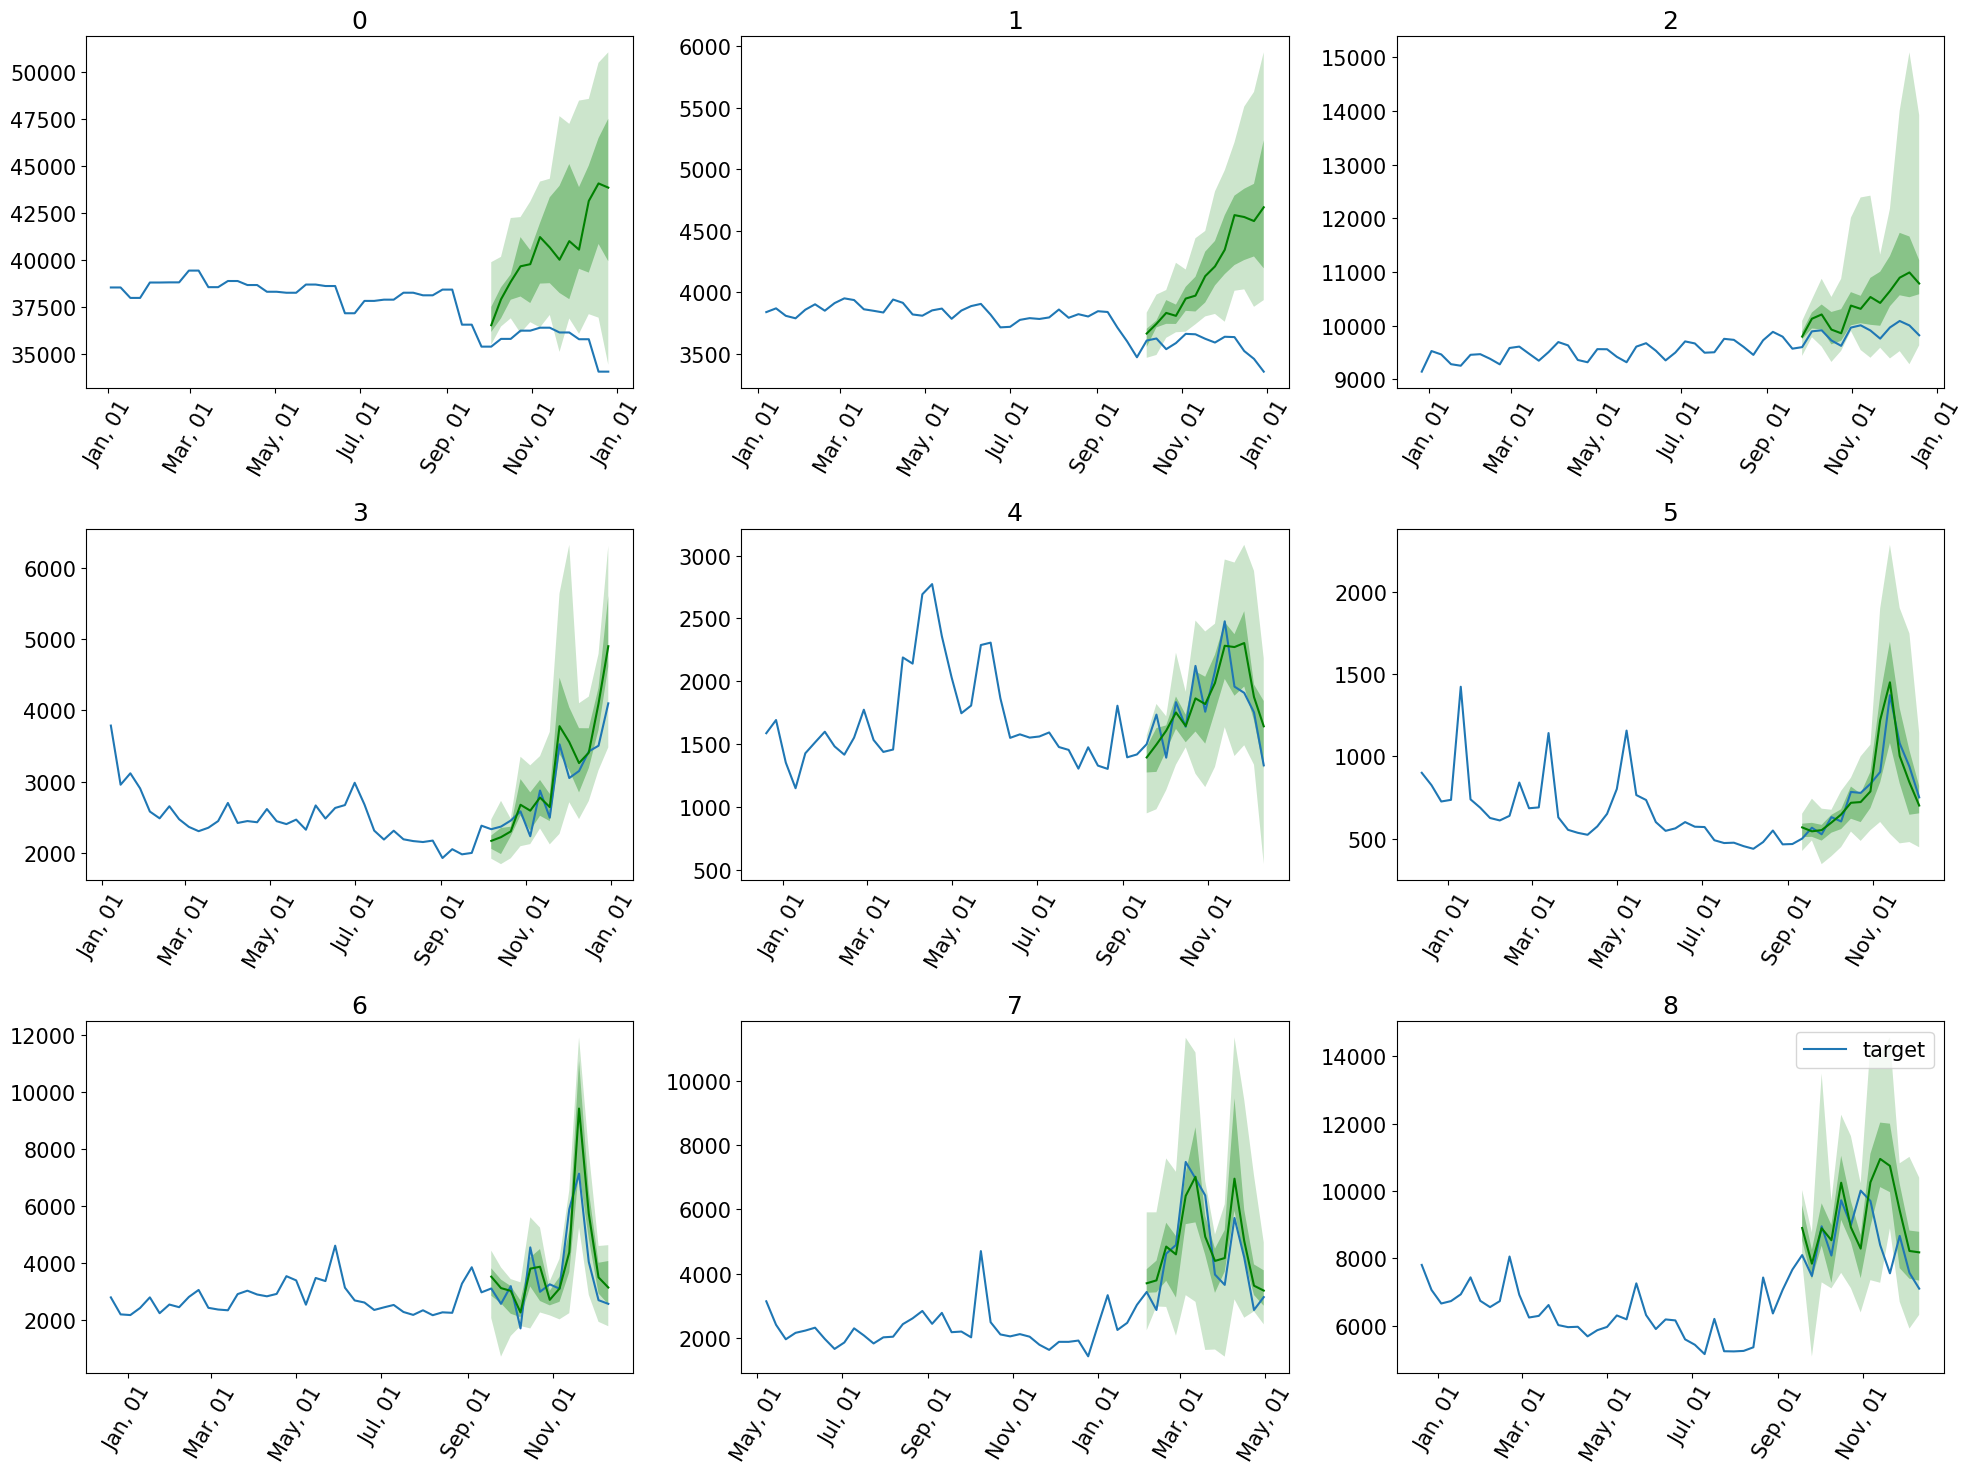

In [12]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [13]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 359it [00:00, 5050.36it/s]
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up seria

In [14]:
agg_metrics

{'MSE': 1170700.6619851338,
 'abs_error': 2550517.760986328,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 9.256080921672167,
 'MAPE': 0.10662711016915201,
 'sMAPE': 0.10469975027463052,
 'MSIS': 60.59921219498997,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1129636.3484786986,
 'Coverage[0.1]': 0.20762802656953072,
 'QuantileLoss[0.2]': 1782076.7260375977,
 'Coverage[0.2]': 0.3308335118920077,
 'QuantileLoss[0.3]': 2189816.1719985963,
 'Coverage[0.3]': 0.4296121705592458,
 'QuantileLoss[0.4]': 2423352.0750305178,
 'Coverage[0.4]': 0.5301049925005357,
 'QuantileLoss[0.5]': 2550517.757217407,
 'Coverage[0.5]': 0.6282408399400043,
 'QuantileLoss[0.6]': 2430114.184729004,
 'Coverage[0.6]': 0.6781658452967645,
 'QuantileLoss[0.7]': 2241556.019190979,
 'Coverage[0.7]': 0.7743732590529248,
 'QuantileLoss[0.8]': 1873360.2161590573,
 'Coverage[0.8]': 0.8512963359760017,
 'QuantileLoss[0.9]': 1262042.025